# Data prep notebook

**Goals** : 

- Prédiction de la position d'un parti pour révéler les logiques partisane
- Prédiction de l'abstention 
- Clustering des lois non-supervisé en fonction des votes



In [55]:
import create_dataset
import pandas as pd
import numpy as np
import re

## Load data

In [56]:
acteurs, votes, scrutins = create_dataset.load_data()

In [57]:
df = scrutins.merge(votes, on='vote_uid')

In [320]:
all_df['vote_data'] = pd.to_datetime(all_df['vote_data'])

## Encode position

In [237]:
df['position'] = df['pour'] > df['contre']
df.head()

,Unnamed: 0_x,parti,abstention,contre,pour,vote_uid,Unnamed: 0_y,vote_objet,vote_demandeur,vote_data,vote_jourSeance,vote_typeCode,vote_typeName,vote_typeMajorite,position,demandeur_parti
0,0,La France Insoumise,0.0,2.0,0.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés,False,[UDI et Indépendants]
1,1,La République en Marche,3.0,11.0,41.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés,True,[UDI et Indépendants]
2,2,Les Républicains,0.0,2.0,13.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés,True,[UDI et Indépendants]
3,3,Mouvement Démocrate,0.0,2.0,6.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés,True,[UDI et Indépendants]
4,4,Indépendant,0.0,0.0,1.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés,True,[UDI et Indépendants]


## Encode partis

In [87]:
df['parti'] = df['parti'].str.replace('Non rattachée', 'Indépendant')
df['parti'] = df['parti'].str.replace('Non rattaché', 'Indépendant')
df['parti'] = df['parti'].str.replace('Non déclaré\(s\)', 'Indépendant')


p = pd.pivot_table(df, values=['pour', 'contre', 'abstention'], index='parti', aggfunc='sum').reset_index()

p['pour/contre'] = p['pour'] / p['contre']
p['abstention/votes'] = p['abstention'] / (p['pour'] + p['contre'] + p['abstention'])
p.sort_values(by='abstention/votes')

,parti,abstention,contre,pour,pour/contre,abstention/votes
6,La République en Marche,2089.0,118817.0,62002.0,0.521828,0.011421
8,Mouvement Démocrate,748.0,14349.0,10820.0,0.754060,0.028861
3,Europe Écologie Les Verts,9.0,70.0,166.0,2.371429,0.036735
4,Indépendant,96.0,878.0,687.0,0.782460,0.057797
9,Parti communiste français,494.0,2356.0,5483.0,2.327250,0.059282
1,Cap sur l'avenir,28.0,181.0,178.0,0.983425,0.072351
5,La France Insoumise,813.0,3322.0,6457.0,1.943709,0.076756
12,Parti socialiste,856.0,2931.0,7185.0,2.451382,0.078017
16,Tavini Huiraatira No Te Ao Maohi - Front de li...,17.0,81.0,104.0,1.283951,0.084158
10,Parti progressiste martiniquais,103.0,345.0,690.0,2.000000,0.090510


In [238]:
all_df = pd.get_dummies(df, columns=['parti'])

## Demandeurs encoding

In [154]:
def find_parti_demandeur(txt):
    if type(txt) == str:
        groupe = re.findall('"(.*?)"', txt)
        #if len(groupe) > 1:
        #    print(groupe)
    else:
        # NaN value for txt
        groupe = []
    groupe = [clean_groupe_name(name) for name in groupe if clean_groupe_name(name) != ""]
    return groupe

def clean_groupe_name(txt):
    txt = txt.strip()
    # Add missing accents
    txt = txt.replace('Les Republicains', 'Les Républicains')
    txt = txt.replace("democrate et republicaine", "démocrate et républicaine")
    txt = txt.replace("Republique", "République")
    # Remove déterminants
    txt = txt.replace("de la Gauche démocrate et républicaine", "Gauche démocrate et républicaine")
    txt = txt.replace("du Mouvement Démocrate et apparentés", "Mouvement Démocrate et apparentés")
    # Add capital letter
    txt = txt.replace("UDI, Agir et indépendants", "UDI, Agir et Indépendants")
    # Remove non relevant text
    txt = txt.replace("President(e) du groupe", "")
    txt = txt.replace("\xa0", " ")
    
    return txt
    

df['demandeur_parti'] = df['vote_demandeur'].apply(find_parti_demandeur)

In [155]:
all_demandeurs = []

def add_all_demandeurs(x):
    for i in x:
        if i not in all_demandeurs:
            all_demandeurs.append(i)

df['demandeur_parti'].apply(add_all_demandeurs)
all_demandeurs

['UDI et Indépendants',
 'Socialistes et apparentés',
 'Gauche démocrate et républicaine',
 'Les Républicains',
 'La France insoumise',
 'UDI, Agir et Indépendants',
 'Libertés et Territoires',
 'La République en Marche',
 'Nouvelle Gauche',
 'Mouvement Démocrate et apparentés',
 'Écologie Démocratie Solidarité',
 'Les Constructifs : républicains, UDI, indépendants',
 'Agir Ensemble']

In [219]:
pros = df[['vote_uid', 'parti', 'demandeur_parti', 'position']].explode("demandeur_parti").pivot_table(values=['position'], index='parti',  columns='demandeur_parti', aggfunc='sum').fillna(0)
all = df[['vote_uid', 'parti', 'demandeur_parti', 'position']].explode("demandeur_parti").pivot_table(values=['vote_uid'], index='parti',  columns='demandeur_parti', aggfunc='count').fillna(0)

In [226]:
agree = pros.to_numpy() / all.to_numpy()
pd.DataFrame(agree, index=pros.index, columns=pros.columns).fillna(0).mean().sort_values()

          demandeur_parti                                   
position  Agir Ensemble                                         0.388889
          La France insoumise                                   0.454163
          Les Républicains                                      0.536434
          Écologie Démocratie Solidarité                        0.536603
          Gauche démocrate et républicaine                      0.545853
          Les Constructifs : républicains, UDI, indépendants    0.561211
          Nouvelle Gauche                                       0.594303
          UDI et Indépendants                                   0.595974
          Socialistes et apparentés                             0.605299
          Libertés et Territoires                               0.608217
          La République en Marche                               0.614896
          UDI, Agir et Indépendants                             0.653625
          Mouvement Démocrate et apparentés                    

In [241]:
# Binary encoding of demandeurs
df_vote_demandeur = pd.get_dummies(df[['vote_uid', 'demandeur_parti']].explode("demandeur_parti"), columns=["demandeur_parti"]).pivot_table(index='vote_uid')
df_vote_demandeur = df_vote_demandeur.reset_index()
df_vote_demandeur.head()

,vote_uid,demandeur_parti_Agir Ensemble,demandeur_parti_Gauche démocrate et républicaine,demandeur_parti_La France insoumise,demandeur_parti_La République en Marche,"demandeur_parti_Les Constructifs : républicains, UDI, indépendants",demandeur_parti_Les Républicains,demandeur_parti_Libertés et Territoires,demandeur_parti_Mouvement Démocrate et apparentés,demandeur_parti_Nouvelle Gauche,demandeur_parti_Socialistes et apparentés,demandeur_parti_UDI et Indépendants,"demandeur_parti_UDI, Agir et Indépendants",demandeur_parti_Écologie Démocratie Solidarité
0,VTANR5L15V1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,VTANR5L15V10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,VTANR5L15V100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,VTANR5L15V1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,VTANR5L15V1001,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
all_df = all_df.merge(df_vote_demandeur, on='vote_uid')

## Vote objets encoding

In [27]:
df.iloc[9751]['vote_objet']

"l'amendement n° 176 de M. Pierre-Henri Dumont après l'article 19 bis du projet de loi pour une immigration maîtrisée, un droit d'asile effectif et une intégration réussie (première lecture)."

## Quick model

In [251]:
features = [c for c in all_df.columns if 'demandeur_' in c or 'parti_' in c]
features.remove('demandeur_parti')
X = all_df[features].to_numpy()
y = all_df['position'].to_numpy()

In [272]:
y.mean() # Roughly balanced dataset

0.5321761540210718

<AxesSubplot:>

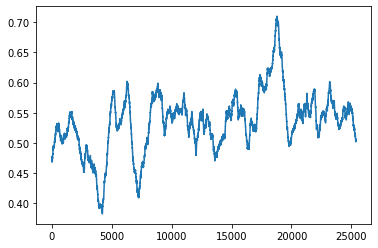

In [343]:
# Evolution of y values through time 

all_df.sort_values('vote_data')['position'].rolling(1000).mean().dropna().reset_index()['position'].plot()

# A bit time sensitive (depends on political context)
# We might need to split our data temporally

In [287]:
from sklearn.model_selection import train_test_split

# In the meanwhile we're lazy we just ignore time 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### Logisitic Regression

In [288]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test, y_test) # accuracy

0.6752557787040546

In [289]:
# Value of coef for each feature. Sensible. 

for f, coef in zip(features, list(log.coef_[0])):
    print(f"{coef:+0.1%} : {f}")

+41.0% : parti_Calédonie Ensemble
-49.5% : parti_Cap sur l'avenir
-16.0% : parti_Debout la France
+40.9% : parti_Europe Écologie Les Verts
-57.0% : parti_Indépendant
+49.3% : parti_La France Insoumise
-132.9% : parti_La République en Marche
-1.9% : parti_Les Républicains
-95.1% : parti_Mouvement Démocrate
+67.1% : parti_Parti communiste français
+31.3% : parti_Parti progressiste martiniquais
+56.1% : parti_Parti radical de gauche
+64.7% : parti_Parti socialiste
+6.1% : parti_Rassemblement national
+6.1% : parti_Régions et peuples solidaires
+25.9% : parti_Tapura Huiraatira
-16.5% : parti_Tavini Huiraatira No Te Ao Maohi - Front de libération de Polynésie
-10.2% : parti_Union des démocrates, radicaux et libéraux
+1.5% : demandeur_parti_Agir Ensemble
+2.9% : demandeur_parti_Gauche démocrate et républicaine
-34.0% : demandeur_parti_La France insoumise
+85.8% : demandeur_parti_La République en Marche
+57.3% : demandeur_parti_Les Constructifs : républicains, UDI, indépendants
-1.7% : demand

### Naive Bayes

In [297]:
from sklearn.naive_bayes import CategoricalNB

nb = CategoricalNB(fit_prior=False)
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.6684350132625995

### Decision tree

In [394]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(min_samples_leaf=5, min_impurity_decrease=0.0002, max_depth=4)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.665403561955286

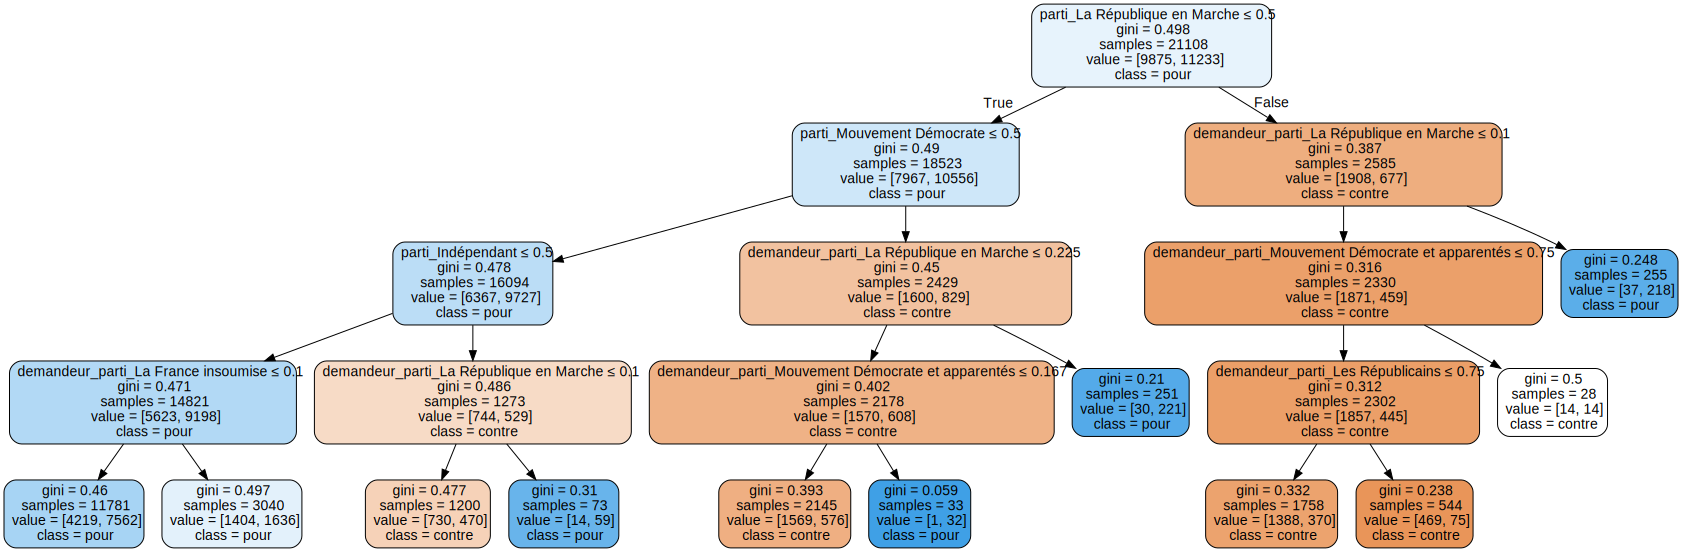

In [395]:
import graphviz 

dot_data = export_graphviz(tree, out_file=None, feature_names=features, class_names=["contre", "pour"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("vote") 
graph

In [397]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(min_samples_leaf=10)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.7353164077302008